# Lesson 6 : Pets revisited - Perso NB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
bs = 64

In [4]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [5]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=.4, max_warp=.4,
                     p_affine=1., p_lighting=1.)

In [6]:
doc(get_transforms)

In [7]:
src = ImageList.from_folder(path).split_by_rand_pct(.2, seed=2)
src

ItemLists;

Train: ImageList (5912 items)
Image (3, 550, 366),Image (3, 416, 500),Image (3, 375, 500),Image (3, 225, 300),Image (3, 417, 500)
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images;

Valid: ImageList (1478 items)
Image (3, 330, 500),Image (3, 500, 375),Image (3, 333, 500),Image (3, 445, 500),Image (3, 382, 500)
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images;

Test: None

In [8]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [9]:
data = get_data(224, bs, 'zeros')

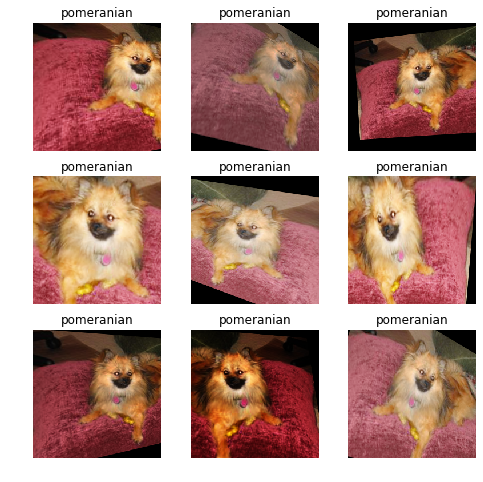

In [10]:
def _plot(i, j, ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [11]:
data = get_data(224, bs)
data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Egyptian_Mau,scottish_terrier,newfoundland,pomeranian,german_shorthaired
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
wheaten_terrier,english_setter,Bengal,chihuahua,pomeranian
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images;

Test: None

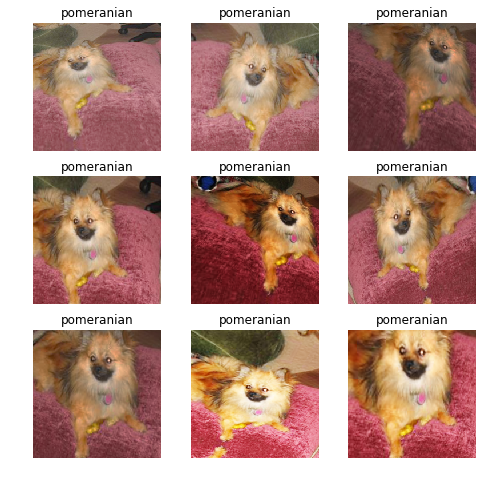

In [12]:
plot_multi(_plot, 3,3, figsize=(8,8))

## Train a model

In [14]:
gc.collect() #Reclaim GPU memory by deletting some variables

learn = cnn_learner(data, models.resnet34, metrics= error_rate, bn_final=True)

In [15]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.501400,1.223318,0.245602,00:42
1,1.467792,0.329921,0.092016,00:33
2,0.911831,0.264064,0.071719,00:33


In [16]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.695982,0.281023,0.062246,00:40
1,0.657713,0.275172,0.058187,00:40


In [17]:
data = get_data(352, bs)
learn.data = data

In [18]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.612237,0.253452,0.054804,01:34
1,0.595711,0.259948,0.054127,01:30


In [22]:
learn.save('352')

## Convolution kernel

In [19]:
data = get_data(352,16)

In [23]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category Abyssinian

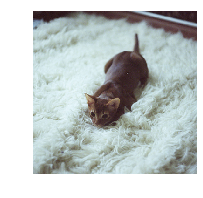

In [35]:
idx= 5
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [53]:
k = tensor([
    [0.  ,-5/3, 1.],
    [-5/3,-5/3, 1.],
    [1.  ,1.  , 1.]
])
k, k.shape

(tensor([[ 0.0000, -1.6667,  1.0000],
         [-1.6667, -1.6667,  1.0000],
         [ 1.0000,  1.0000,  1.0000]]), torch.Size([3, 3]))

In [54]:
k = k.expand(1,3,3,3)/6 # Pytorch expects minibatches so we create a mini-batch on 1 element
k, k.shape

(tensor([[[[ 0.0000, -0.2778,  0.1667],
           [-0.2778, -0.2778,  0.1667],
           [ 0.1667,  0.1667,  0.1667]],
 
          [[ 0.0000, -0.2778,  0.1667],
           [-0.2778, -0.2778,  0.1667],
           [ 0.1667,  0.1667,  0.1667]],
 
          [[ 0.0000, -0.2778,  0.1667],
           [-0.2778, -0.2778,  0.1667],
           [ 0.1667,  0.1667,  0.1667]]]]), torch.Size([1, 3, 3, 3]))

In [79]:
t = data.valid_ds[idx][0].data; t.shape

torch.Size([3, 352, 352])

In [66]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [67]:
edge = F.conv2d(t[None], k)

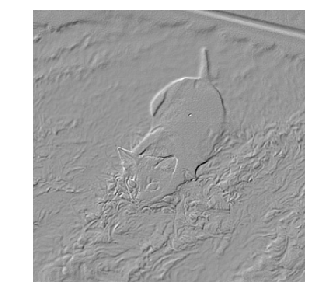

In [68]:
show_image(edge[0], figsize=(5,5))

In [74]:
data.c

37

In [80]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [81]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

## HeatMap

In [85]:
m = learn.model.eval()

In [93]:
xb, _ = data.one_item(x)
xb.shape

torch.Size([1, 3, 352, 352])

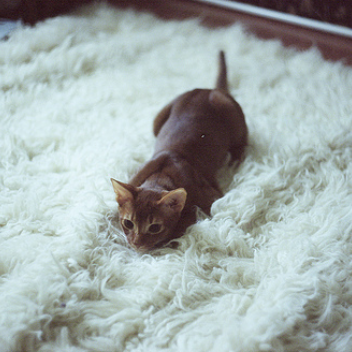

In [94]:
xb_im = Image(data.denorm(xb)[0])
xb_im

In [95]:
xb = xb.cuda()

In [97]:
from fastai.callbacks.hooks import *

In [100]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [101]:
hook_a, hook_g = hooked_backward()

In [106]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [108]:
avg_acts = acts.mean(0) # 0 is in the axis of the channels
avg_acts.shape

torch.Size([11, 11])

In [111]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma')

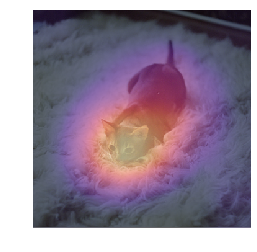

In [112]:
show_heatmap(avg_acts)